ПРЯМАЯ ЗАДАЧА: ДОПЛЕР С УЧЁТОМ RAMP
  ✓ naif0010.tls
  ✗ Отсутствует: pck00010.tpc
  ✓ earth_720101_070426.bpc
  ✓ de442s.bsp
  ✓ mgs_ab1.bsp
  ✓ dsnstns.bsp
Загружено SPICE kernels: 5

[1] Загрузка данных...
  Начальное состояние КА относительно Марса:
    Положение: (32343.8, 14006.1, -24913.2) км
    |r| = 43162.0 км
    |v| = 0.7607 км/с
Загрузка доплеровских данных...
  Загружено записей: 1972
  Выделено сессий: 5

  Опорная частота (ref_freq):
    Значение: 70205.932 МГц = 70.205932 ГГц

[2] Интегрирование орбиты...
  Начало: 1997-09-19T04:05:30
  Длительность: 2 суток, шаг: 60 сек
    Шаг 0/2880 (0.0%)
    Шаг 100/2880 (3.5%)
    Шаг 200/2880 (6.9%)
    Шаг 300/2880 (10.4%)
    Шаг 400/2880 (13.9%)
    Шаг 500/2880 (17.4%)
    Шаг 600/2880 (20.8%)
    Шаг 700/2880 (24.3%)
    Шаг 800/2880 (27.8%)
    Шаг 900/2880 (31.2%)
    Шаг 1000/2880 (34.7%)
    Шаг 1100/2880 (38.2%)
    Шаг 1200/2880 (41.7%)
    Шаг 1300/2880 (45.1%)
    Шаг 1400/2880 (48.6%)
    Шаг 1500/2880 (52.1%)
    

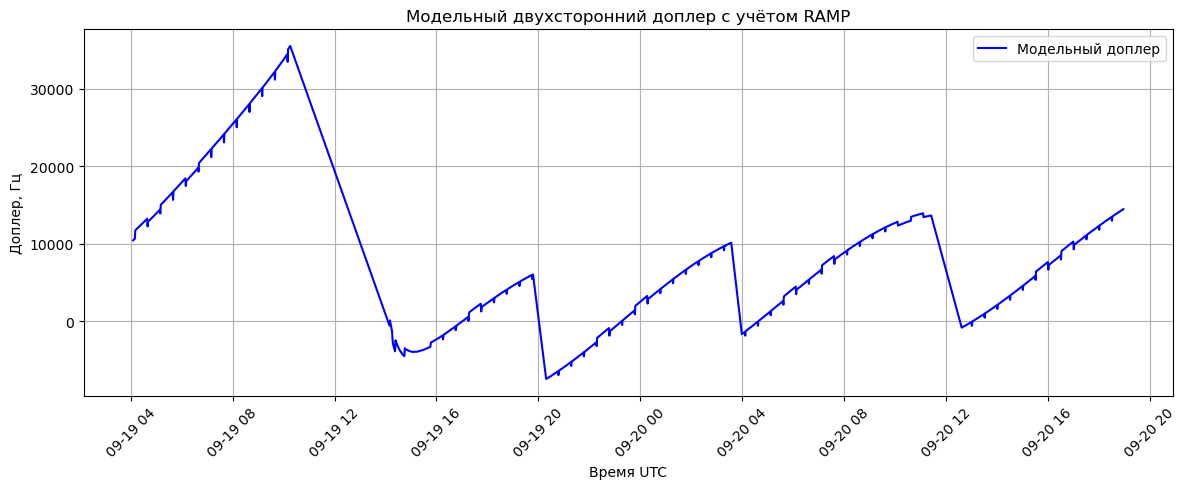

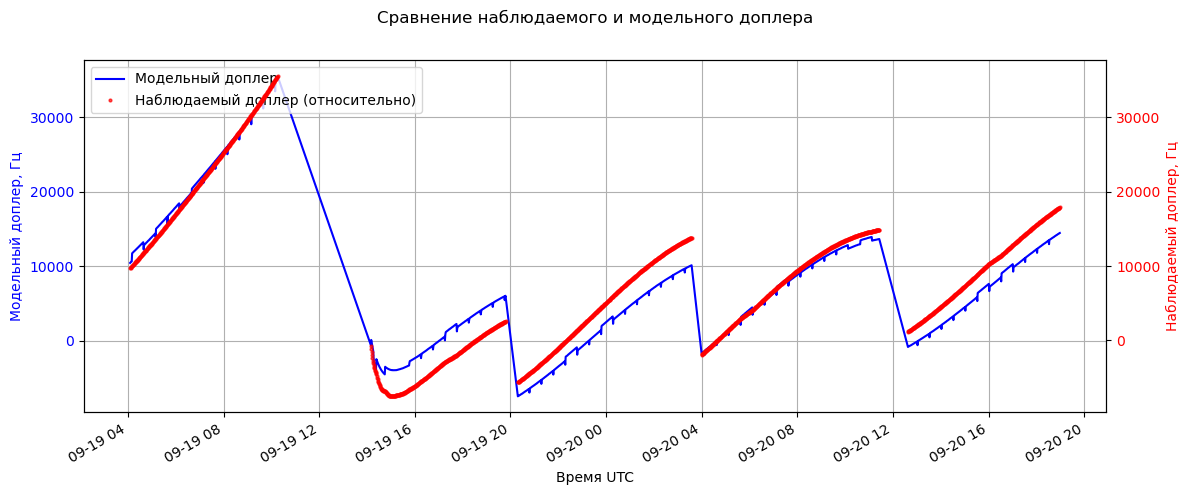

            datetime_utc    doppler_hz  doppler_model_hz  v_radial_m_s
0    1997-09-19 04:05:30   9734.105515      10426.991402      0.044525
1    1997-09-19 04:06:30   9794.050559      10494.795496      0.044815
2    1997-09-19 04:07:30   9854.052135      10539.998225      0.045008
3    1997-09-19 04:08:30   9914.109458      10596.501637      0.045249
4    1997-09-19 04:09:30   9972.223184      10620.279250      0.045351
...                  ...           ...               ...           ...
1967 1997-09-20 18:54:30  17738.213296      14304.795624      0.061084
1968 1997-09-20 18:55:30  17775.133664      14338.697685      0.061229
1969 1997-09-20 18:56:30  17812.001676      14372.599747      0.061374
1970 1997-09-20 18:57:30  17848.047944      14429.103183      0.061615
1971 1997-09-20 18:58:30  17884.043885      14451.704557      0.061711

[1972 rows x 4 columns]


In [39]:
"""
Прямая задача: работа с вариациями доплера с учётом RAMP. 
"""

import numpy as np
import pandas as pd
import spiceypy as spice
from scipy.interpolate import interp1d
from scipy.signal import detrend
import os
import matplotlib.pyplot as plt
from datetime import datetime

# Константы
KERNEL_DIR = './spice_data/'
GEOMETRY_FILE = './output_data/mgs_geometry.csv'
DOPPLER_FILE = './output_data/mgs_doppler_CLEANED.csv'
RAMP_FILE = './output_data/mgs_ramp_CLEANED.csv'
OUTPUT_DIR = './output_data/'

GM = {
    'sun':       132712440041.93938,
    'mercury':   22031.868551,
    'venus':     324858.592,
    'earth':     398600.435507,
    'moon':      4902.800118,
    'mars':      42828.375816,
    'jupiter':   126712764.100,
    'saturn':    37940584.841,
    'uranus':    5794556.400,
    'neptune':   6836527.100,
}

C_LIGHT = 299792.458  # km/s
MARS_RE = 3396.19     # km

DSN_STATIONS = {
    15: {'lon': -116.887, 'lat': 35.422, 'height': 973.21},
    45: {'lon': 148.978, 'lat': -35.402, 'height': 674.35},
    65: {'lon': -4.255, 'lat': 40.427, 'height': 833.85},
}

# SPICE
def load_kernels():
    """Загружает SPICE kernels."""
    kernels = [
        'naif0010.tls',        # Leap seconds (обязательно!)
        'pck00010.tpc',        # Базовый PCK - ДОБАВЬТЕ ЭТОТ
        'earth_720101_070426.bpc',
        'de442s.bsp',          # Планетарные эфемериды
        'mgs_ab1.bsp',         # MGS орбита
        'dsnstns.bsp',         # DSN станции
    ]
    
    loaded = []
    for k in kernels:
        path = os.path.join(KERNEL_DIR, k)
        if os.path.exists(path):
            try:
                spice.furnsh(path)
                loaded.append(k)
                print(f"  ✓ {k}")
            except Exception as e:
                print(f"  ✗ {k}: {e}")
        else:
            print(f"  ✗ Отсутствует: {k}")
    
    print(f"Загружено SPICE kernels: {len(loaded)}")
    return loaded

def get_body_state(body_id, t_et):
    """Состояние тела в SSB J2000."""
    state, _ = spice.spkezr(str(body_id), t_et, 'J2000', 'NONE', '0')
    return np.array(state[:3]), np.array(state[3:6])

def get_mars_state(t_et):
    return get_body_state(4, t_et)

def get_earth_state(t_et):
    return get_body_state(3, t_et)


# Станции DSN
def get_dsn_station_position(station_id, t_et, frame='J2000', observer='EARTH'):
    """
    Получает точное положение DSN станции через SPICE.
    
    Args:
        station_id: ID станции (15, 45, 65)
        t_et: эфемеридное время (секунды)
        frame: система координат
        observer: точка отсчёта
        
    Returns:
        np.array: положение [x, y, z] в км
    """
    station_name = f'DSS-{station_id}'
    try:
        state, lt = spice.spkezr(station_name, t_et, frame, 'NONE', observer)
        return np.array(state[:3])
    except Exception as e:
        print(f"Ошибка получения позиции станции {station_name}: {e}")
        # Резервный вариант
        return np.array([0.0, 0.0, 0.0])


# Динамика космического аппарата
def compute_acceleration(t_et, r_sc_mars, v_sc_mars):
    """Ускорение КА относительно Марса."""
    r_mars, v_mars = get_mars_state(t_et)
    r_sc = r_mars + r_sc_mars
    
    a_sc = np.zeros(3)
    a_mars = np.zeros(3)
    
    bodies = [(10, GM['sun']), (1, GM['mercury']), (2, GM['venus']),
              (3, GM['earth']), (301, GM['moon']), (4, GM['mars']),
              (5, GM['jupiter']), (6, GM['saturn']), (7, GM['uranus']),
              (8, GM['neptune'])]
    
    for naif_id, gm in bodies:
        try:
            r_body, _ = get_body_state(naif_id, t_et)
        except:
            continue
        
        # Ускорение КА от тела
        r_to = r_body - r_sc
        d = np.linalg.norm(r_to)
        if d > 1e-10:
            a_sc += gm * r_to / d**3
        
        # Ускорение Марса от тела (кроме самого Марса)
        if naif_id != 4:
            r_to_mars = r_body - r_mars
            d_mars = np.linalg.norm(r_to_mars)
            if d_mars > 1e-10:
                a_mars += gm * r_to_mars / d_mars**3
    
    return a_sc - a_mars

def rk5_step(t, state, dt, accel_func):
    c = [0, 1/5, 3/10, 4/5, 8/9, 1, 1]
    a = [[], [1/5], [3/40, 9/40], [44/45, -56/15, 32/9],
         [19372/6561, -25360/2187, 64448/6561, -212/729],
         [9017/3168, -355/33, 46732/5247, 49/176, -5103/18656],
         [35/384, 0, 500/1113, 125/192, -2187/6784, 11/84]]
    b = [35/384, 0, 500/1113, 125/192, -2187/6784, 11/84, 0]
    
    r, v = state[:3], state[3:6]
    k_r, k_v = [None]*7, [None]*7
    k_r[0], k_v[0] = v, accel_func(t, r, v)
    
    for i in range(1, 7):
        r_t = r + dt * sum(a[i][j] * k_r[j] for j in range(i))
        v_t = v + dt * sum(a[i][j] * k_v[j] for j in range(i))
        k_r[i], k_v[i] = v_t, accel_func(t + c[i]*dt, r_t, v_t)
    
    r_new = r + dt * sum(b[i] * k_r[i] for i in range(7))
    v_new = v + dt * sum(b[i] * k_v[i] for i in range(7))
    return np.concatenate([r_new, v_new])

def save_orbit_to_csv(t0_et, orbit_data, filename):
    r_mars, _ = get_mars_state(t0_et)
    r_sun, _  = get_body_state(10, t0_et)
    mars_sun = r_sun - r_mars

    rows = []
    for t, state in zip(orbit_data['times'], orbit_data['states']):
        rows.append({
            'datetime_utc': spice.et2utc(t, 'ISOC', 3),
            'mgs_x_km': state[0],
            'mgs_y_km': state[1],
            'mgs_z_km': state[2],
            'mgs_vx_km_s': state[3],
            'mgs_vy_km_s': state[4],
            'mgs_vz_km_s': state[5],
        })

    df = pd.DataFrame(rows)

    df['mars_sun_x_km'] = mars_sun[0]
    df['mars_sun_y_km'] = mars_sun[1]
    df['mars_sun_z_km'] = mars_sun[2]

    df.to_csv(filename, index=False)

def integrate_orbit(t0, state0, days=2.0, dt=60.0):
    """Интегрирует орбиту на заданное время."""
    t_end = t0 + days * 86400.0
    n_steps = int((t_end - t0) / dt)
    
    times, states = [t0], [state0.copy()]
    t, state = t0, state0.copy()
    
    for step in range(n_steps):
        state = rk5_step(t, state, dt, compute_acceleration)
        t += dt
        times.append(t)
        states.append(state.copy())
        
        # Прогресс
        if step % 100 == 0:
            print(f"    Шаг {step}/{n_steps} ({step/n_steps*100:.1f}%)")
    
    return {'times': np.array(times), 'states': np.array(states)}

def create_interpolator(orbit_data):
    """Создаёт интерполятор для орбиты."""
    times, states = orbit_data['times'], orbit_data['states']
    
    interp_r = interp1d(times, states[:, :3], axis=0, kind='cubic',
                        fill_value='extrapolate', bounds_error=False)
    interp_v = interp1d(times, states[:, 3:6], axis=0, kind='cubic',
                        fill_value='extrapolate', bounds_error=False)
    
    def get_sc_state(t):
        r_mars, v_mars = get_mars_state(t)
        r_sc = r_mars + interp_r(t)
        v_sc = v_mars + interp_v(t)
        return r_sc, v_sc
    
    return get_sc_state


def solve_light_time(t_recv, get_sc_state, station_id, max_iter=20, tol=1e-12):
    """
    Двухстороннее световое время:
    t3 = t_recv (приём на Земле)
    t2 = время излучения КА
    t1 = время передачи с Земли
    """

    t3 = t_recv
    t2 = t3
    t1 = t3

    for _ in range(max_iter):
        # --- Downlink: t2 -> t3 ---
        r_st_t3 = get_dsn_station_position(station_id, t3, 'J2000', 'EARTH')
        r_earth_t3, _ = get_earth_state(t3)
        r_st_ssb_t3 = r_earth_t3 + r_st_t3

        r_sc_t2, _ = get_sc_state(t2)

        rho_dn = np.linalg.norm(r_st_ssb_t3 - r_sc_t2)
        t2_new = t3 - rho_dn / C_LIGHT

        # --- Uplink: t1 -> t2 ---
        r_st_t1 = get_dsn_station_position(station_id, t1, 'J2000', 'EARTH')
        r_earth_t1, _ = get_earth_state(t1)
        r_st_ssb_t1 = r_earth_t1 + r_st_t1

        r_sc_t2_new, _ = get_sc_state(t2_new)
        rho_up = np.linalg.norm(r_sc_t2_new - r_st_ssb_t1)
        t1_new = t2_new - rho_up / C_LIGHT

        # Проверка сходимости
        if abs(t1_new - t1) < tol and abs(t2_new - t2) < tol:
            t1, t2 = t1_new, t2_new
            break

        t1, t2 = t1_new, t2_new

    return t1, t2


def compute_ramp_integral(t_start, t_end, station_id, ramp_df):
    """
    Интеграл fT(t) по интервалу с учётом рамп таблицы.
    t_start, t_end в ET
    """
    station_ramp = ramp_df[ramp_df['ramp_station_id']==station_id].sort_values('ramp_start_et')
    ramp_times = station_ramp['ramp_start_et'].values
    ramp_freqs = station_ramp['ramp_start_freq_hz'].values
    ramp_rates = station_ramp['ramp_rate_hz_s'].values
    total = 0.0
    current = t_start
    while current < t_end:
        idx = np.searchsorted(ramp_times, current, side='right') - 1
        if idx < 0: idx = 0
        t_ramp_start = ramp_times[idx]
        t_ramp_end = ramp_times[idx+1] if idx+1 < len(ramp_times) else t_end
        t_interval_end = min(t_ramp_end, t_end)
        f_dot = ramp_rates[idx]
        if current != t_ramp_start:
            f0 = ramp_freqs[idx] + f_dot*(current-t_ramp_start)
        else:
           f0 = ramp_freqs[idx]
        f0 = ramp_freqs[idx]
        t_rel_start = current - t_ramp_start
        t_rel_end = t_interval_end - t_ramp_start
        total += f0*(t_rel_end-t_rel_start) + 0.5*f_dot*(t_rel_end - t_rel_start)**2
        current = t_interval_end
    return total


def compute_doppler_with_ramp(TT, Tc, ramps_rx, ramps_tx, get_sc_state, station_rx, station_tx, f_ref):
    """
    Вычисление двухстороннего доплера с точной интеграцией ramped F2.

    TT  : среднее время измерения (ET)
    Tc  : интервал измерения (сек)
    ramps_rx : DataFrame с рампами станции приёма
    ramps_tx : DataFrame с рампами станции передачи
    station_rx : DSS ID станции приёма
    station_tx : DSS ID станции передачи
    """
    M2 = 880.0 / 749.0
    
    # интервал приёма
    t3_start = TT - 0.5 * Tc
    t3_end   = TT + 0.5 * Tc

    # световое время (t1=uplink, t2=КА transmit)
    t1_start, t2_start = solve_light_time(t3_start, get_sc_state, station_rx)
    t1_end, t2_end = solve_light_time(t3_end,   get_sc_state, station_rx)
    
    # интегралы частоты по RAMP
    I_rx = compute_ramp_integral(t3_start, t3_end, station_rx, ramps_rx)
    I_tx = compute_ramp_integral(t1_start, t1_end, station_tx, ramps_tx)
    
    # Доплер в Гц
    doppler = (M2 * (I_rx - I_tx) / Tc - 450000.0) / 2.22
    # doppler = M2*f_ref - M2 * I_tx / Tc

    return doppler   

# Загрузка данных

def load_initial_conditions(geometry_file):
    """Загружает начальные условия из файла геометрии."""
    df = pd.read_csv(geometry_file)
    df['datetime_utc'] = pd.to_datetime(df['datetime_utc'])
    
    # Берём первую запись как начальное состояние
    row = df.iloc[0]
    
    # Конвертируем время в ET
    t0_et = spice.str2et(row['datetime_utc'].strftime('%Y-%m-%dT%H:%M:%S'))
    
    # Начальное состояние (относительно Марса)
    state0 = np.array([
        row['mgs_x_km'], row['mgs_y_km'], row['mgs_z_km'],
        row['mgs_vx_km_s'], row['mgs_vy_km_s'], row['mgs_vz_km_s'],
    ])
    
    return t0_et, state0, df

def load_doppler_data(doppler_file):
    print("Загрузка доплеровских данных...")
    df = pd.read_csv(doppler_file)

    df['datetime_utc'] = pd.to_datetime(df['datetime_utc'])

    required = [
        'datetime_utc',
        'doppler_hz',
        'receiving_station_id',
        'ref_freq_mhz',
        'compression_time'
    ]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"В DOPPLER_FILE нет колонок: {missing}")

    df = df.sort_values('datetime_utc')

    df['time_diff'] = df['datetime_utc'].diff().dt.total_seconds()
    session_change = (
        (df['time_diff'] > 300) |
        (df['receiving_station_id'] != df['receiving_station_id'].shift())
    )
    df['session_id'] = session_change.cumsum()

    print(f"  Загружено записей: {len(df)}")
    print(f"  Выделено сессий: {df['session_id'].nunique()}")

    return df

def load_ramp_data(ramp_file):
    df = pd.read_csv(ramp_file)
    df['ramp_datetime_utc'] = pd.to_datetime(df['ramp_datetime_utc'])

    required = [
        'ramp_datetime_utc',
        'ramp_station_id',
        'ramp_rate_hz_s'
    ]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"В RAMP_FILE нет колонок: {missing}")
    
    df['ramp_start_et'] = df['ramp_datetime_utc'].apply(lambda x: spice.str2et(str(x)))
    
    return df


# Визуализация модельного и наблюдаемого доплера
def plot_doppler(doppler_df):
    import matplotlib.pyplot as plt

    fig, ax1 = plt.subplots(figsize=(12,5))

    # Модельный доплер на первой оси
    ax1.plot(doppler_df['datetime_utc'], doppler_df['doppler_model_hz'], 
             'b-', label='Модельный доплер', linewidth=1.5)
    ax1.set_xlabel('Время UTC')
    ax1.set_ylabel('Модельный доплер, Гц', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.grid(True)

    # Создаём вторую ось для наблюдаемого доплера
    ax2 = ax1.twinx()

    # Наблюдаемый доплер относительно опорной частоты
    doppler_obs_rel = doppler_df['doppler_hz']  # уже малый доплер, в Гц
    ax2.plot(doppler_df['datetime_utc'], doppler_obs_rel, 
             'r.', label='Наблюдаемый доплер (относительно)', markersize=4, alpha=0.7)
    ax2.set_ylabel('Наблюдаемый доплер, Гц', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    # Заголовок и оформление
    fig.suptitle('Сравнение наблюдаемого и модельного доплера')
    fig.autofmt_xdate()
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)  # чтобы заголовок не обрезался

    # Легенда объединяем с двух осей
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper left')

    plt.show()


def main():
    print("="*70)
    print("ПРЯМАЯ ЗАДАЧА: ДОПЛЕР С УЧЁТОМ RAMP")
    print("="*70)

    # 1. Загрузка ядер SPICE
    load_kernels()

    # 2. Загрузка начальных условий
    print("\n[1] Загрузка данных...")
    t0_et, state0, geometry_df = load_initial_conditions(GEOMETRY_FILE)

    print(f"  Начальное состояние КА относительно Марса:")
    print(f"    Положение: ({state0[0]:.1f}, {state0[1]:.1f}, {state0[2]:.1f}) км")
    print(f"    |r| = {np.linalg.norm(state0[:3]):.1f} км")
    print(f"    |v| = {np.linalg.norm(state0[3:]):.4f} км/с")

    # 3. Загрузка доплеровских данных
    doppler_df = load_doppler_data(DOPPLER_FILE)
    ramp_df = load_ramp_data(RAMP_FILE)
    

    if len(doppler_df) == 0:
        print("Ошибка: нет данных для обработки!")
        return

    print(f"\n  Опорная частота (ref_freq):")
    print(f"    Значение: {doppler_df['ref_freq_mhz'].iloc[0]:.3f} МГц = {doppler_df['ref_freq_mhz'].iloc[0]/1e3:.6f} ГГц")

    # 4. Интегрирование орбиты
    print("\n[2] Интегрирование орбиты...")
    print(f"  Начало: {spice.et2utc(t0_et, 'ISOC', 0)}")
    print(f"  Длительность: 2 суток, шаг: 60 сек")

    orbit_data = integrate_orbit(t0_et, state0, days=2.0, dt=60.0)
    save_orbit_to_csv(
        t0_et,
        orbit_data,
        './output_data/doppler_results_integrated.csv'
    )
    get_sc_state = create_interpolator(orbit_data)

    # Статистика орбиты
    radii = np.linalg.norm(orbit_data['states'][:, :3], axis=1)
    print(f"  Радиус орбиты: {radii.min():.1f} - {radii.max():.1f} км")
    
    # 5. Вычисление доплера
    print("\n[3] Вычисление доплера...")

    Tc = 5.0
    results = []
    v_radials = []
    for _, row in doppler_df.iterrows():
        t3 = spice.str2et(str(row['datetime_utc']))
        station_rx = int(row['receiving_station_id'])
        station_tx = int(row['transmitting_station_id'])

        f_ref = row['ref_freq_mhz'] * 1e6

        doppler = compute_doppler_with_ramp(TT=t3, Tc=Tc,
                                           ramps_rx=ramp_df, ramps_tx=ramp_df,
                                           get_sc_state=get_sc_state,
                                           station_rx=station_rx,
                                           station_tx=station_tx, f_ref=f_ref)
        results.append(doppler)
        # Радиальная скорость
        v_radial = doppler / f_ref * C_LIGHT
        v_radials.append(v_radial)

    doppler_df['doppler_model_hz'] = results
    doppler_df['v_radial_m_s'] = v_radials

    # 5. Построение графика
    plt.figure(figsize=(12,5))
    plt.plot(doppler_df['datetime_utc'], doppler_df['doppler_model_hz'], 'b-', label='Модельный доплер')
    plt.xlabel('Время UTC')
    plt.ylabel('Доплер, Гц')
    plt.title('Модельный двухсторонний доплер с учётом RAMP')
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plot_doppler(doppler_df)

    print(doppler_df[['datetime_utc','doppler_hz','doppler_model_hz','v_radial_m_s']])
    spice.kclear()


if __name__ == "__main__":
    results_df = main()
    